# **Lab Assignment 3**
🎯**Objective:** Implement molecular dynamics to obtain structures that will be used to train Machine Learning Interatomic Potential (MLIP).

---
# Import and Initialization
---

## **General Workflow**
✅1) **Import and Initialization**
- To begin with, let's import the essential (for this assignment) libraries.
- Fill the parameter **struc** name. The file with **struc** name will be created and all calculations will be saved there. 
- Other cells must be run without any changes.
- For the first time you need to fill **struc**. But in the next times, when you will use this notebook, you can just completely run all cells in part *Import and Initialization* without any changes.

## Library

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
from ase.io import write, read
from ase.calculators.vasp import Vasp
from ase.geometry import cell_to_cellpar
from ase.build import make_supercell, graphene
from ase import Atoms, Atom
from ase.units import GPa
from calorine.calculators import CPUNEP, GPUNEP
from calorine.tools import relax_structure
from PIL import Image

from mendeleev import element
from pymatgen.io.vasp import Vasprun
from pymatgen.core.structure import Structure
from pymatgen.electronic_structure.core import Spin
from ase.calculators.espresso import Espresso, EspressoProfile
#from pymatgen.io.espresso.outputs import PWxml

from itertools import chain
import random
import time
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import pylab

import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *

from threading import Thread
from multiprocessing import Pool, Process
from collections import defaultdict
import shutil
from pathlib import Path, PurePath

pd.options.plotting.backend = "plotly"

> **IMPORTANT**

> Insert **YOUR STRUCTURE NAME** file that will be used further. All calculations will be saved there.

In [2]:
# Insert structure name
struc = 'Diamane' # for example: Diamane

## Import Working Directories

MAIN DIRECTORY

In [3]:
main_dir = create_folder(main_dir=Path(os.getcwd()), folder='Lab_works')
if main_dir.exists():
    print('Main Directory:')
    print(main_dir)
else:
    print('Directory does not exists')

Folder Lab_works already exists
Main Directory:
/home/heimao/Desktop/Khasan/Lab_works


Load directories

In [4]:
general_paths_dir = create_folder(main_dir=main_dir, folder='utils') / 'general_paths.yaml'

if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

# Create Others name key in pathes
if 'Others' not in general_paths.keys():
    general_paths['utils'] = Munch()
    general_paths['utils']['__val__'] = main_dir / 'utils'

# Create structure name key in pathes
if struc not in general_paths.keys():
    general_paths[struc] = Munch()
    general_paths[struc]['__val__'] = create_folder(main_dir=main_dir, folder=struc)

Folder utils already exists


Create working directories and save them

In [5]:
save_path(
    main_dir=create_folder(main_dir=general_paths[struc].__val__, folder='3.MLIP'), 
    dir_name='qe_mlip',
    general_paths_dir=general_paths_dir,
    munch_dict=general_paths[struc],
    general_dict=general_paths,
    )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].qe_mlip.__val__, folder='3.1.MD_Simulation'),
        dir_name='md_simulation',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['qe_mlip'],
        general_dict=general_paths,
        )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].qe_mlip.__val__, folder='3.2.NEP_Train'),
        dir_name='nep_train',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['qe_mlip'],
        general_dict=general_paths,
        )

# save_path(
#         main_dir=create_folder(main_dir=general_paths[struc].qe_opt_params.__val__, folder='1.3.Relaxation'),
#         dir_name='relaxation',
#         general_paths_dir=general_paths_dir,
#         munch_dict=general_paths[struc]['qe_opt_params'],
#         general_dict=general_paths,
#         )

# with (general_paths_dir).open(mode='w') as f:
#     yaml.dump(munch_to_dict(general_paths), f)
#     f.close()

Folder 3.MLIP already exists
File path is saved
Folder 3.1.MD_Simulation already exists
File path is saved
Folder 3.2.NEP_Train already exists
File path is saved


---
# PART 3 - QE Molecular Dynamics
---

## Functions and Files

### **General Workflow**
✅2) **Initialize functions and download essential files**
- Mentioned below functions will be used for general calculation of some parameters. In most cases, they **DO NOT** need to change.

> **IMPORTANT** Please, check **POSCAR** and **PSEUDOPOTENTIALS** in the **UTILS** directory. <br>

- There is no need to add the code, just run the cells

In [6]:
def parse_md_energies(outfile, ry_to_ev = 13.6056980659, au_to_fs = 0.02418884):
    potential = []
    total = []
    iterations = []
    kinetic = []
    kinetic_total = []
    temperature = []
    natoms = 0
    dt = 0
    with open(outfile) as f:
        for line in f:
            # Parameters
            if not natoms and 'number of atoms/cell      =' in line:
                natoms = int(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
            elif not dt and '     Time step             =' in line:
                dt = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
            # SCF convergence data
            elif "!    total energy" in line and "Entering" not in line:
                potential.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
            elif "internal energy E=F+TS" in line:
                total.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
            # MD data
            elif "     Entering Dynamics:    iteration" in line:
                iterations.append(int(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
            elif "kinetic energy (Ekin)" in line:
                kinetic.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
            elif "     Ekin + Etot (const)   =" in line and "Entering" not in line:
                kinetic_total.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
            elif "     temperature           =" in line:
                temperature.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0]))
    
    kinetic = np.array(kinetic) * ry_to_ev
    potential = np.array(potential) * ry_to_ev / natoms
    total = np.array(total) * ry_to_ev / natoms
    kinetic_total = np.array(kinetic_total) * ry_to_ev / natoms

    # TIMESTEP calculations
    dt_fs = dt * au_to_fs * 2
    nstep = len(iterations)
    timesteps = np.arange(0, nstep) * dt_fs

    return np.array(iterations), timesteps, kinetic, potential, total, np.array(temperature)

def create_xyz(
        main_dir: str, 
        md_dir: str, 
        T_values: list, 
        step: int, 
        train_size: float
        ) -> None:
    # Choose Desired Structures
    desired_strucs = list()
    for value in T_values:
        desired_strucs.append(read(md_dir / str(value) / 'espresso.pwo', index=':'))
    desired_strucs = list(chain.from_iterable(desired_strucs))

    # Shuffle Dataset
    shuffled_structures = desired_strucs[0::step]
    random.shuffle(shuffled_structures)
    data_size = len(shuffled_structures)
    print(f'Full Dataset: {data_size} structures\n')

    # Create Train and Test Datasets
    write(main_dir / "train.xyz", shuffled_structures[:int(data_size*train_size)])
    print(f'Train Dataset: {int(data_size*train_size)} structures')
    write(main_dir / "test.xyz", shuffled_structures[int(data_size*train_size):])
    print(f'Validation Dataset: {data_size - int(data_size*train_size)} structures')

    return int(data_size*train_size), data_size - int(data_size*train_size)

def create_nep_in(
        filename: str,
        type1: str = '',
        version: str = '4',
        cutoff: str = '8 4',
        n_max: str = '4 4',
        basis_size: str = '8 8',
        l_max: str = '4 2 1',
        neuron: str = '30',
        lambda_1: str = '1',
        lambda_2: str = '1',
        lambda_e: str = '1.0',
        lambda_f: str = '1.0',
        lambda_v: str = '0.1',
        force_delta: str = '0',
        batch: str = '1000',
        population: str = '50',
        generation: str = '100000'
) -> None:
    with open(filename, 'w') as f:
        if type1:
            f.write(f"type          {type1}\n")
        else:
            return 'Type is not mentioned'
        
        f.write(f"version       {version}\n")
        f.write(f"cutoff        {cutoff}\n")
        f.write(f"n_max         {n_max}\n")
        f.write(f"basis_size    {basis_size}\n")
        f.write(f"l_max         {l_max}\n")
        f.write(f"neuron        {neuron}\n")
        f.write(f"lambda_1      {lambda_1}\n")
        f.write(f"lambda_2      {lambda_2}\n")
        f.write(f"lambda_e      {lambda_e}\n")
        f.write(f"lambda_f      {lambda_f}\n")
        f.write(f"lambda_v      {lambda_v}\n")
        f.write(f"force_delta   {force_delta}\n")
        f.write(f"batch         {batch}\n")
        f.write(f"population    {population}\n")
        f.write(f"generation    {generation}\n")

        f.close()

def RMSELoss(yhat, y):
    return np.sqrt(np.mean((yhat-y)**2))

def WMAPELoss(yhat, y):
    return np.sum(np.abs(yhat - y)) / np.sum(np.abs(y)) *100

**QE-run.sh**

In [7]:
%%writefile {general_paths[struc].qe_mlip.__val__  / 'qe_run.sh'}
#!/bin/bash

srun -n 20 pw.x < espresso.pwi > espresso.pwo

Overwriting /home/heimao/Desktop/Khasan/Lab_works/Diamane/3.MLIP/qe_run.sh


## PART 3.1 - QE Molecular Dynamics Simulation

### **General Workflow**
✅3) **Implement MD calculation**
- You need to change function **get_vcmd_params** by parameters for your structure.

- Also, please, fulfill parameters: **cutoff_energy**, **kpts_vals**, **supercell**.

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/3.QE_MD/3.1.MD_Simulation <br>

🌟Run calculations: 
**sbatch md_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**

### MD Calculation

In [100]:
%%writefile {general_paths[struc].qe_mlip.md_simulation.__val__  / 'QE_MD_script.py'}

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--supercell', type=str, help='Enter supercell size: (e.g. [2, 2, 1])')
parser.add_argument('--kpts', type=str, help='Enter k-points grid: (e.g. 12, 12, 1)')
parser.add_argument('--nstep', type=int, help='Enter number of steps for MD: (e.g. 2000 steps)')
parser.add_argument('--dt', type=float, help='Enter step size: (e.g. 0.5 fs)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--tempw', type=int, help='Enter begining temperature: (e.g. 500 K)')
args = parser.parse_args()

kpts = ast.literal_eval(args.kpts)
supercell = ast.literal_eval(args.supercell)

general_paths_dir = create_folder(main_dir=Path(args.main_dir), folder='utils') / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

print('Current directory:')
curr_dir = Path(os.getcwd())
print(curr_dir)
command = 'sh qe_run.sh'

def get_vcmd_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        kpts: list,
        nstep: int,
        dt: float,
        ecutwfc: int,
        tempw: int,
):
    vcmd_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'calculation': 'md', # ibrion=-1
                'restart_mode': 'from_scratch',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high',
                'iprint': 1,
                'nstep': nstep,
                'dt': dt,
                'etot_conv_thr': 1.0e-5,
                'forc_conv_thr': 1.0e-4,

            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_global_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'nosym': True, # isym=0
                'occupations': 'smearing', # ismear = 0
                'smearing': 'cold', # ismear = 0
                'degauss': 0.05, # sigma = 0.05
            },
            'electrons': {
                'conv_thr': 1.0e-6,
                'electron_maxstep': 500,
                'mixing_beta': 0.7,
                'diagonalization': 'cg',
            },
            'ions': {
                # 'pot_extrapolation': 'second-order',
                # 'wfc_extrapolation': 'second-order',
                'ion_temperature': 'initial',
                'tempw': tempw, # TEBEG
            },
            'cell': {
                'cell_dofree': '2Dxy',
                'press': 0,
            }
        },
        'kpts': kpts,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return vcmd_params

if __name__ == '__main__':
    # Read structure
    structure = read(general_paths.utils.__val__ / 'POSCAR') #.repeat(supercell)

    # MD Simulation
    vcmd_params = get_vcmd_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        kpts=kpts,
        nstep=args.nstep,
        dt=args.dt,
        ecutwfc=args.cutoff_energy,
        tempw=args.tempw,
    ) 
    calc = Espresso(**vcmd_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nMD {args.rotation_angle} finished successfully\n')

Writing /home/heimao/Desktop/Khasan/Lab_works/Diamane/3.MLIP/3.1.MD_Simulation/QE_MD_script.py


In [101]:
# Choose optimal cut-off energy
cutoff_energy = 45
# Choose optimal kpoints grid
kpts_vals = [12, 12, 1]
# Choose supercell grid
supercell = [1, 1, 1]

T_values = [500, 1000]
nstep = 2000
dt = 30 # ~ 0.7 fs

for temp in T_values:
    # Create folder
    folder_name = create_folder(main_dir=general_paths[struc].qe_mlip.md_simulation.__val__, folder=str(temp))
    # Copy folders
    os.system(f'cp {general_paths[struc].qe_mlip.__val__  / "qe_run.sh"} {folder_name}')
    os.system(f"cp {general_paths[struc].qe_mlip.md_simulation.__val__  / 'QE_MD_script.py'} {folder_name}")
    os.system(f"cp {general_paths[struc].qe_opt_params.relaxation.__val__  / f'{struc}.xml'} {folder_name}")
    os.system(f"cp -r {general_paths[struc].qe_opt_params.relaxation.__val__  / f'{struc}.save'} {folder_name}")
    os.system(f"cp -r {general_paths[struc].qe_opt_params.relaxation.__val__  / f'espresso.pwo'} {folder_name}")
    # SCRIPT.SH
    create_bash_script(
    script_filename=folder_name / 'md_script.sh',
    job_name='qe-md',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=20,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command=f'python QE_MD_script.py \
        --struc={struc} \
        --main_dir={main_dir} \
        --supercell="{str(supercell)}" \
        --kpts="{str(kpts_vals)}" \
        --nstep={nstep} \
        --dt={dt} \
        --cutoff_energy="{cutoff_energy}" \
        --tempw={temp}')


Folder 500 is created
Folder 1000 is created


> **RUN CALCULATIONS** <br>

`sbatch md_script.sh`

### MD Visualisation

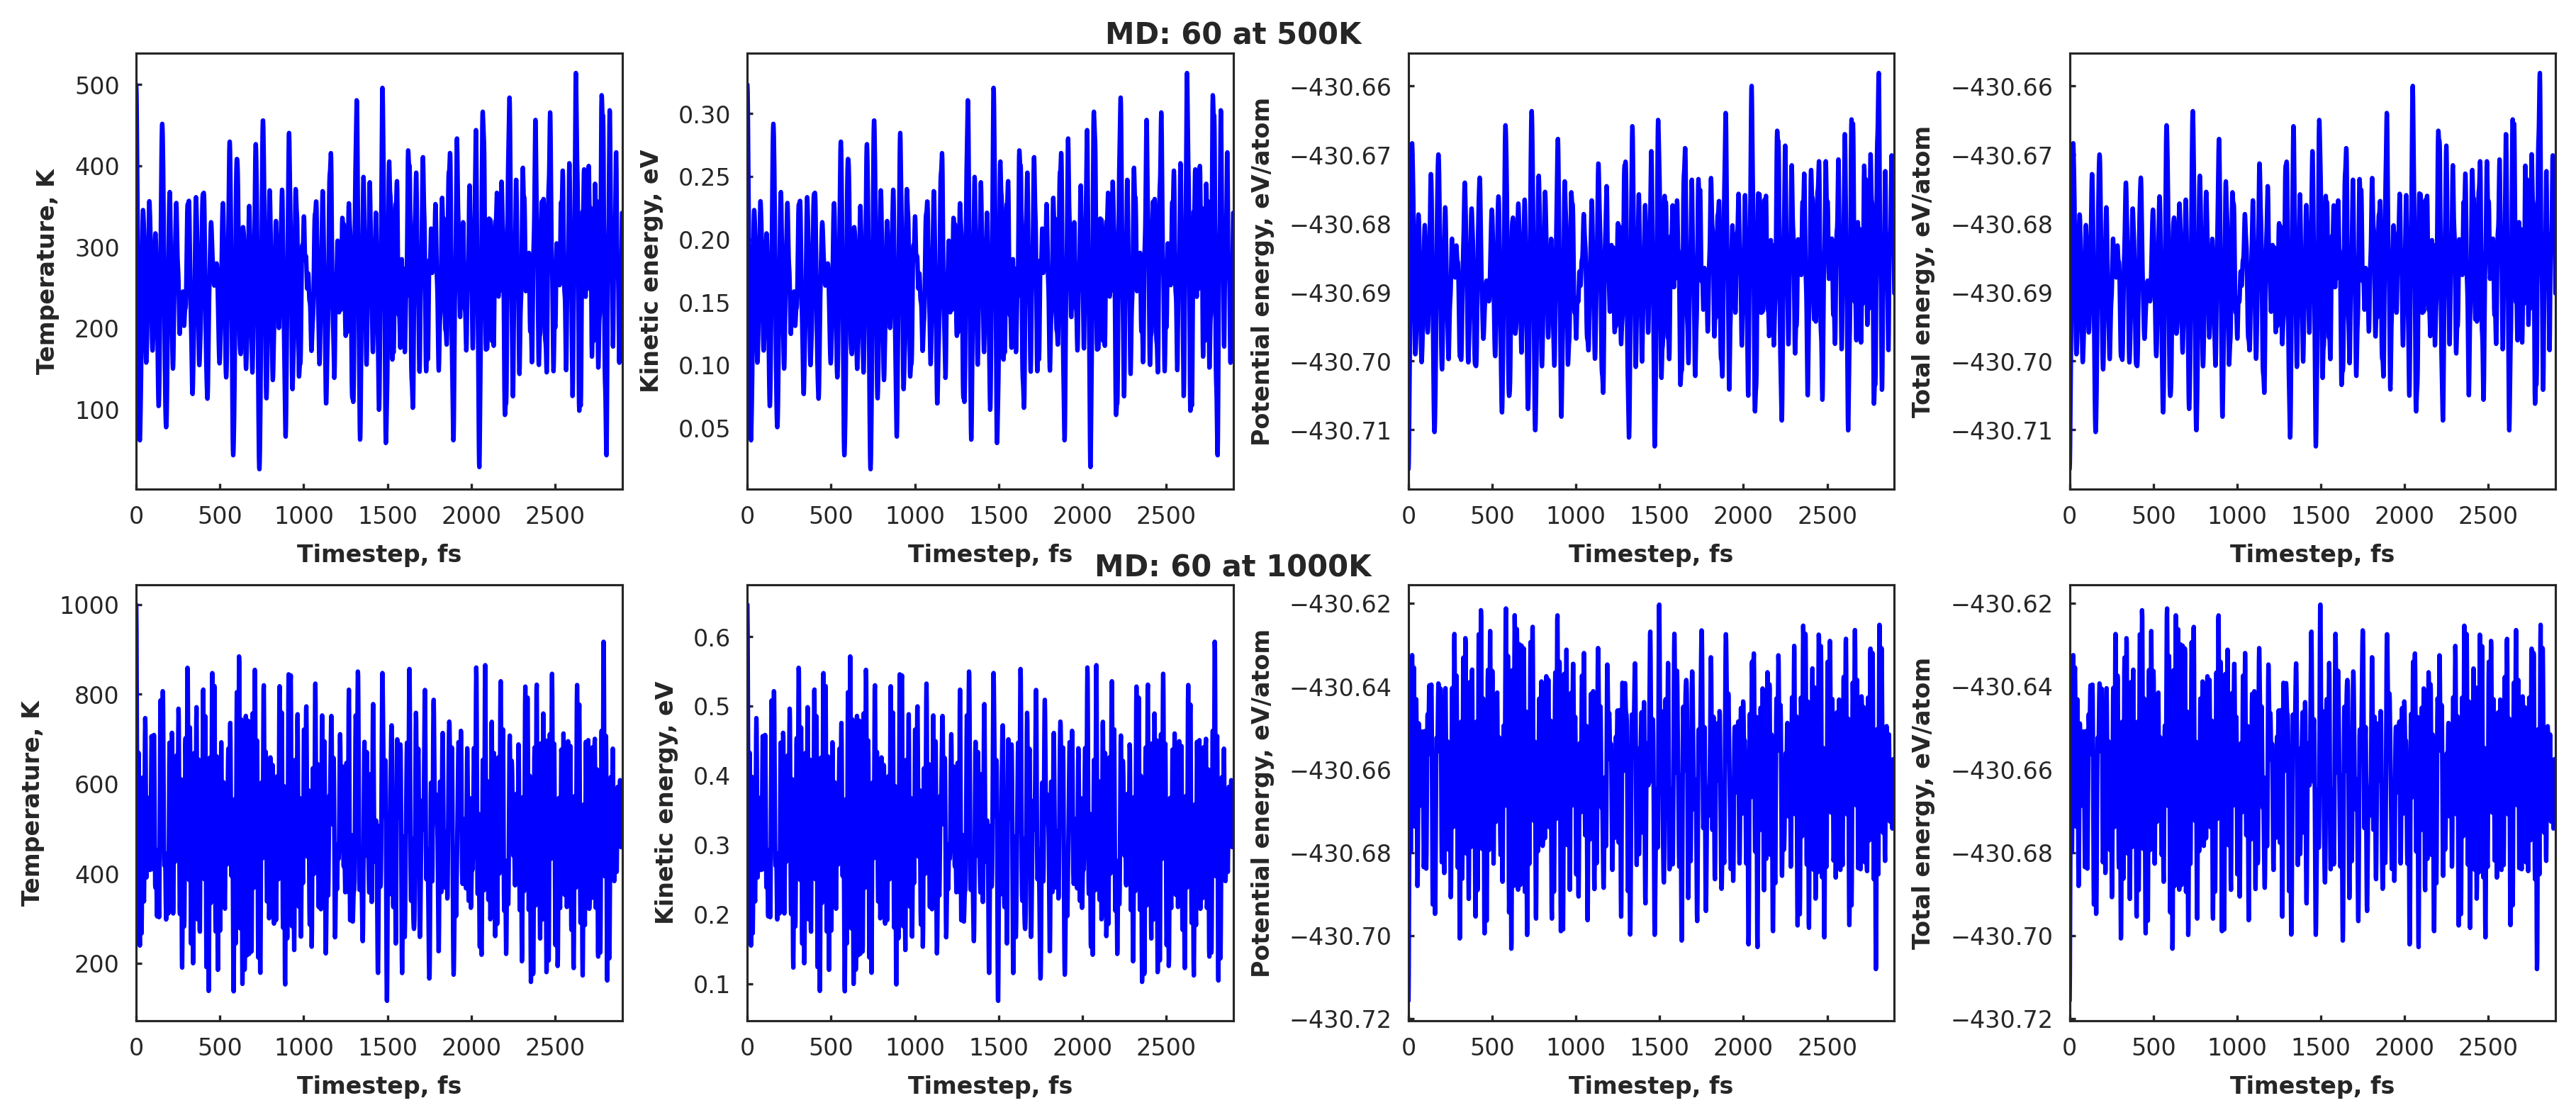

In [ ]:
plt.style.use('seaborn-v0_8-paper')

struc = 'Dm_F_F'
angles = ['60',] # '27', '21'
fig, ax = plt.subplots(len(angles)*len(T_values), 4, figsize=(12, 5), dpi=300, constrained_layout=True)
potim = 0.5
count = 0
for angle in angles:
    rotation_angle = str(angle)
    for temp in [500, 1000]: # T_values:
        iterations, timesteps_fs, kinetic_eV, potential_eV, total_eV, temperature_K = parse_md_energies(general_paths[struc].qe_mol_dyn.md_simulation.__val__ / rotation_angle / str(temp) / 'espresso.pwo')
        # Temperature
        ax_ij = [count, 0]
        ax[ax_ij[0], ax_ij[1]].plot(timesteps_fs, temperature_K, label='Temperature', color='blue', linewidth=1.5)
        # ax[ax_ij[0], ax_ij[1]].plot(timestep, [value,]*timestep.shape[0], linestyle='--', color='red', linewidth=1.0)
        ax[ax_ij[0], ax_ij[1]].set_xlabel('Timestep, fs', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_ylabel('Temperature, K', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_xlim([(timesteps_fs).min(), (timesteps_fs).max()])
        ax[ax_ij[0], ax_ij[1]].xaxis.set_ticks_position('bottom')
        ax[ax_ij[0], ax_ij[1]].yaxis.set_ticks_position('left')
        ax[ax_ij[0], ax_ij[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
        #ax[ax_ij[0], ax_ij[1]].legend(loc="upper right", fontsize=8, frameon=False)

        # Kinetic Energy
        ax_ij = [count, 1]
        ax[ax_ij[0], ax_ij[1]].plot(timesteps_fs, kinetic_eV, ls='-', label='Kinetic energy', color='blue', linewidth=1.5)
        #ax[ax_ij[0], ax_ij[1]].text(1.0, 1.2, f'MD: {angle} at {value}K', transform=ax[ax_ij[0], ax_ij[1]].transAxes, fontsize=8) #
        ax[ax_ij[0], ax_ij[1]].set_xlabel('Timestep, fs', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_ylabel('Kinetic energy, eV', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_xlim([(timesteps_fs).min(), (timesteps_fs).max()])
        ax[ax_ij[0], ax_ij[1]].xaxis.set_ticks_position('bottom')
        ax[ax_ij[0], ax_ij[1]].yaxis.set_ticks_position('left')
        ax[ax_ij[0], ax_ij[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
        #ax[ax_ij[0], ax_ij[1]].legend(loc="upper left", fontsize=8, frameon=False)

        # Potential Energy
        ax_ij = [count, 2]
        ax[ax_ij[0], ax_ij[1]].plot(timesteps_fs, potential_eV, ls='-', label='Potential energy', color='blue', linewidth=1.5)
        #ax[ax_ij[0], ax_ij[1]].text(1.0, 1.2, f'MD: {angle} at {value}K', transform=ax[ax_ij[0], ax_ij[1]].transAxes, fontsize=8) #
        ax[ax_ij[0], ax_ij[1]].set_xlabel('Timestep, fs', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_ylabel('Potential energy, eV/atom', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_xlim([(timesteps_fs).min(), (timesteps_fs).max()])
        ax[ax_ij[0], ax_ij[1]].xaxis.set_ticks_position('bottom')
        ax[ax_ij[0], ax_ij[1]].yaxis.set_ticks_position('left')
        ax[ax_ij[0], ax_ij[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
        #ax[ax_ij[0], ax_ij[1]].legend(loc="upper left", fontsize=8, frameon=False)

        # Total Energy
        ax_ij = [count, 3]
        ax[ax_ij[0], ax_ij[1]].plot(timesteps_fs, total_eV, ls='-', label='Total energy', color='blue', linewidth=1.5)
        #ax[ax_ij[0], ax_ij[1]].text(1.0, 1.2, f'MD: {angle} at {value}K', transform=ax[ax_ij[0], ax_ij[1]].transAxes, fontsize=8) #
        ax[ax_ij[0], ax_ij[1]].set_xlabel('Timestep, fs', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_ylabel('Total energy, eV/atom', fontsize=8, fontweight='bold', labelpad=5)
        ax[ax_ij[0], ax_ij[1]].set_xlim([(timesteps_fs).min(), (timesteps_fs).max()])
        ax[ax_ij[0], ax_ij[1]].xaxis.set_ticks_position('bottom')
        ax[ax_ij[0], ax_ij[1]].yaxis.set_ticks_position('left')
        ax[ax_ij[0], ax_ij[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
        #ax[ax_ij[0], ax_ij[1]].legend(loc="upper left", fontsize=8, frameon=False)

        fig.text(1, 1.02, f'MD: {angle} at {temp}K', transform=ax[count, 1].transAxes, ha='center', fontsize=10, fontweight='bold')
        count += 1

plt.show()

## PART 3.2 - NEP Training

### **General Workflow**
✅3) **Train NEP model**
- Run the cells below to create necessary files

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/3.MLIP/3.2.NEP_Train <br>

🌟Run calculations: 
**sbatch nep_script.sh** <br>

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**

### Train Model

In [ ]:
struc = 'Dm_F_F'
md_strucs_path = general_paths[struc].qe_mlip.md_simulation.__val__
# Create Train | Validation Dataset
train_size, valid_size = create_xyz(
    main_dir=general_paths[struc].qe_mlip.nep_train.__val__,
    md_dir=general_paths[struc].qe_mlip.md_simulation.__val__,
    T_values=T_values,
    step=1,
    train_size=0.75,
)

# Create Test Datasets
data_for_test = list(chain.from_iterable([read(general_paths[struc].qe_mlip.md_simulation.__val__ / '500' / 'espresso.pwo', index=':'),]))
write(general_paths[struc].qe_mlip.nep_train.__val__ / "data_for_test.xyz", data_for_test)
print(f'Test Dataset: {len(data_for_test)} structures')

# Coefficient for Model
lambda_1 = np.round(np.sqrt(train_size) / 1000, 3)

# Choose correct params for Input Files
create_nep_in(
    filename=general_paths[struc].qe_mlip.nep_train.__val__ / 'nep.in',
    type1='2 C F',
    cutoff='6 3',
    n_max='10 10',
    basis_size='8 8',
    l_max='4 2 0',
    neuron='40',
    lambda_1=lambda_1,
    lambda_2=lambda_1,
    lambda_e='0.4',
    lambda_f='1.0',
    lambda_v='0.1',
    batch='1000',
    population='60',
    generation='1000000',
)
create_bash_script(
    script_filename=general_paths[struc].qe_mlip.nep_train.__val__ / 'nep_script.sh',
    job_name='nep-gpu',
    partition='gpu',
    nodes=1,
    memory='6G',
    exclude='ct05',
    ntasks=1,
    cpus_per_task=1,
    gpus=1,
    time=72,
    command=f'srun nep'
)

Full Dataset: 137 structures

Train Dataset: 102 structures
Validation Dataset: 35 structures
Test Dataset: 78 structures


> **RUN CALCULATIONS** <br>

`sbatch nep_script.sh`

### Training Results

Energy & Forces Data Processing: **Figure 1 | Figure 2**

In [ ]:
train_data = read(general_paths[struc].qe_mlip.nep_train.__val__ / 'train.xyz', index=':')
valid_data = read(general_paths[struc].qe_mlip.nep_train.__val__ / 'test.xyz', index=':')
test_data = read(general_paths[struc].qe_mlip.nep_train.__val__ / 'data_for_test.xyz', index=':')

total_energy = {}
total_forces = {}
for i, label in enumerate(['train', 'valid', 'test']):
    total_energy[label] = np.array([])
    total_forces[label] = np.array([])
    if label == 'train':
        for j in range(len(train_data)):
            total_energy[label] = np.append( total_energy[label], train_data[j].get_total_energy() / train_data[j].get_number_of_atoms() )
            total_forces[label] = np.append( total_forces[label], np.linalg.norm(train_data[j].get_forces(), axis=1) )
    if label == 'valid':
        for j in range(len(valid_data)):
            total_energy[label] = np.append( total_energy[label], valid_data[j].get_total_energy() / valid_data[j].get_number_of_atoms() )
            total_forces[label] = np.append( total_forces[label], np.linalg.norm(valid_data[j].get_forces(), axis=1) )

    if label == 'test':
        for j in range(len(test_data)):
            total_energy[label] = np.append( total_energy[label], test_data[j].get_total_energy() / test_data[j].get_number_of_atoms() )
            total_forces[label] = np.append( total_forces[label], np.linalg.norm(test_data[j].get_forces(), axis=1) )
    
    total_forces[label].sort()

Smoothing Forces: **Figure 2**

In [ ]:
mean_force = 0
window_size = 10
total_forces['train_smooth'] = np.array([])
total_forces['valid_smooth'] = np.array([])
total_forces['test_smooth'] = np.array([])

for i in range(0, len(total_forces['train'])//window_size):
    # Train Force Smoothing
    mean_force = total_forces['train'][i*window_size:(i+1)*window_size].mean()
    total_forces['train_smooth'] = np.append(total_forces['train_smooth'], mean_force)
    # Valid Force Smoothing
    mean_force = total_forces['valid'][i*window_size:(i+1)*window_size].mean()
    total_forces['valid_smooth'] = np.append(total_forces['valid_smooth'], mean_force)
    # Test Force Smoothing
    mean_force = total_forces['test'][i*window_size:(i+1)*window_size].mean()
    total_forces['test_smooth'] = np.append(total_forces['test_smooth'], mean_force)

Read Training Data: **Figure 3 | Figure 4 | Figure 5**

In [ ]:
nep_train_path = general_paths[struc].qe_mlip.nep_train.__val__
loss = pylab.loadtxt(nep_train_path / 'loss.out')
energy_train = pylab.loadtxt(nep_train_path / 'energy_train.out')
energy_test = pylab.loadtxt(nep_train_path / 'energy_test.out')
force_train = pylab.loadtxt(nep_train_path / 'force_train.out')
force_test = pylab.loadtxt(nep_train_path / 'force_test.out')

Make Test Prediction: **Figure 3 | Figure 4**

In [ ]:
test_data = read(general_paths[struc].qe_mlip.nep_train.__val__ / 'data_for_test.xyz', index=':')
calc = CPUNEP(general_paths[struc].qe_mlip.nep_train.__val__ / 'nep.txt')
predict_energy_test, predict_forces_test, calc_forces_test = np.array([]), [], []
for struc in test_data:
    calc_forces_test.append(struc.get_forces())
    struc.calc = calc
    predict_energy_test = np.append(predict_energy_test, struc.get_total_energy() / struc.get_number_of_atoms())
    predict_forces_test.append(struc.get_forces())

predict_energy_test = np.array(predict_energy_test)
predict_forces_test = np.array(predict_forces_test)
calc_forces_test = np.array(calc_forces_test)

Compare DFT vs NEP phonon dos: **Figure 6**

In [ ]:
with (general_paths.Dm_F_F.optimized_strucs.nep_phonon.figures.__val__ / '60' / "nep_phonon_points.pkl").open(mode='rb') as f:
    nep_phonon_pts = pickle.load(f)
    f.close()

with (general_paths.Dm_F_F.phonon_props.figures.__val__ / '60' / "dft_phonon_points.pkl").open(mode='rb') as f:
    dft_phonon_pts = pickle.load(f)
    f.close()
    
y_nep = (nep_phonon_pts['freq']*33.35641)
y_dft = (dft_phonon_pts['freq']*33.35641)

# # RMSE & WMAPE for Energy | Forces
# rmse_energy = RMSELoss(yhat=predict_energy_test, y=total_energy['test'])*1000
# rmse_forces = RMSELoss(yhat=predict_forces_test[:1500, :, :].flatten(), y=calc_forces_test[:1500, :, :].flatten())*1000

# RMSE & WMAPE for Phonon Structure
rmse_phonon_struc = RMSELoss(yhat=nep_phonon_pts['freq'].reshape(-1)*33.35641, y=dft_phonon_pts['freq'].reshape(-1)*33.35641)
wmape_phonon_struc = WMAPELoss(yhat=nep_phonon_pts['freq'].reshape(-1)*33.35641, y=dft_phonon_pts['freq'].reshape(-1)*33.35641)

### Visualisation

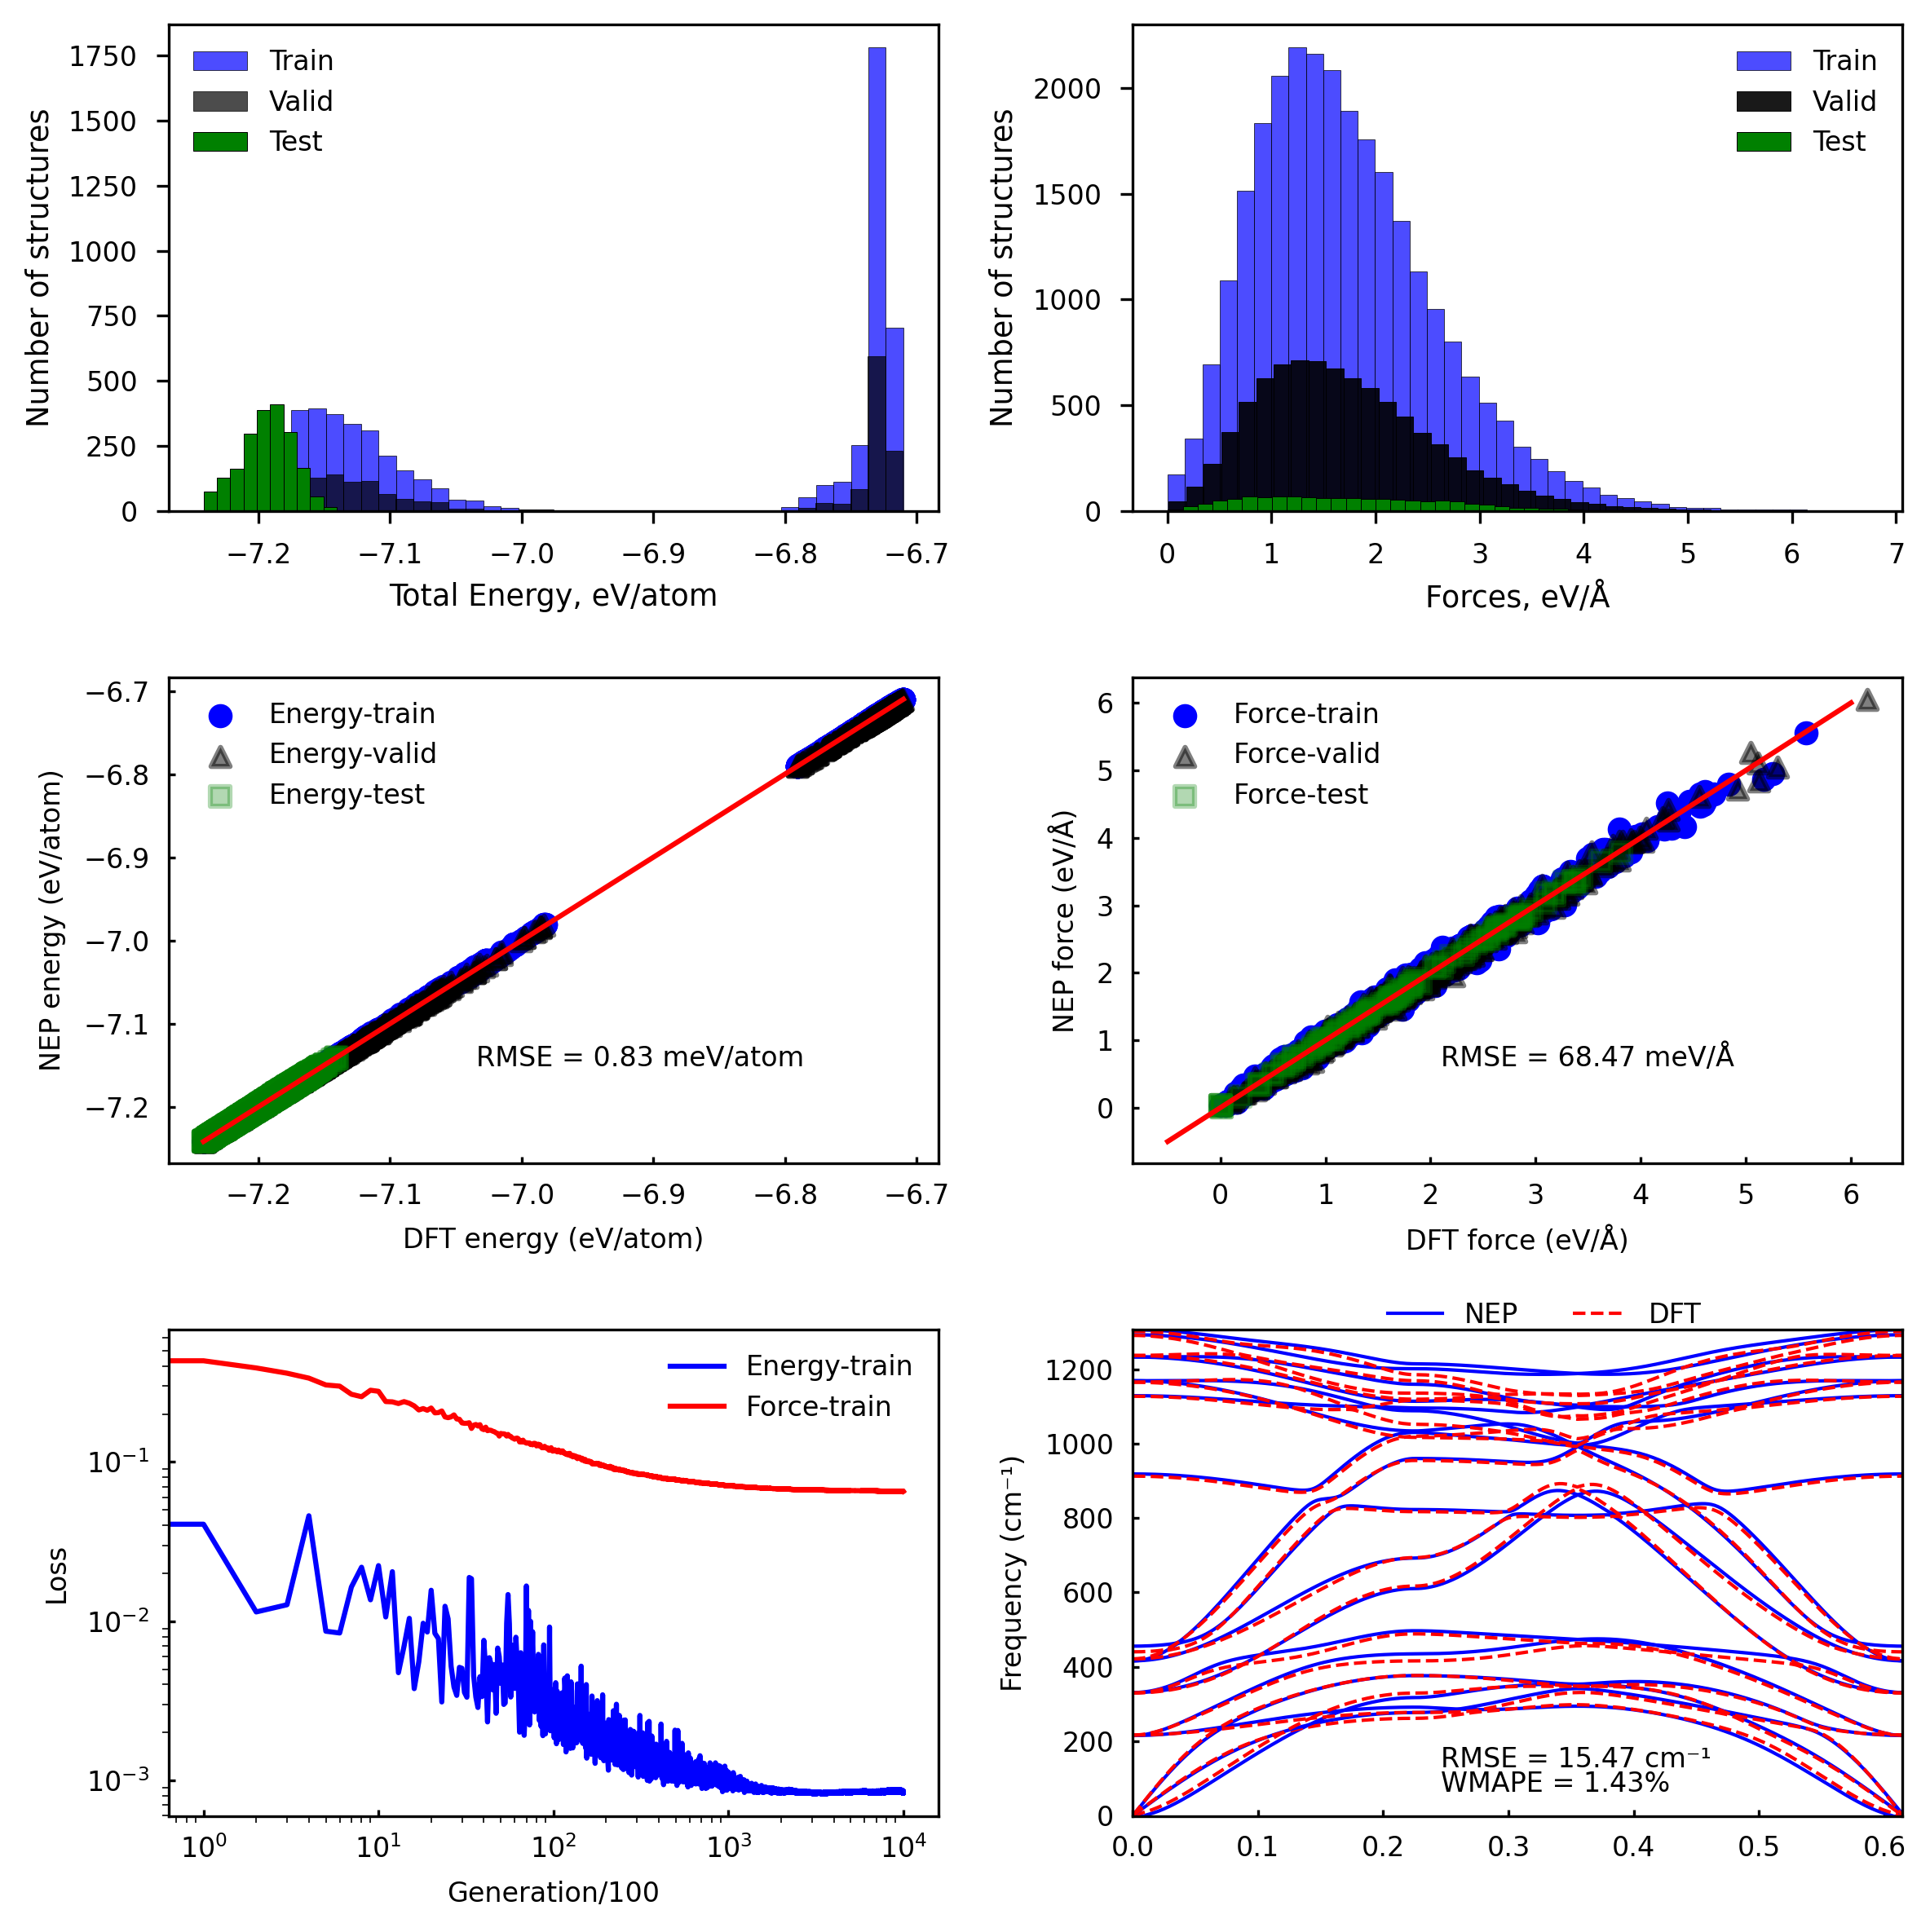

In [ ]:
plt.style.use('seaborn-v0_8-paper')

fig, ax = plt.subplots(3, 2, figsize=(8, 8), dpi=300)

# Energy Distribution
ax_i_j = [0, 0]
ax[ax_i_j[0], ax_i_j[1]].hist(total_energy['train'], bins=40, facecolor='blue', edgecolor='black', alpha=0.7, label='Train')
ax[ax_i_j[0], ax_i_j[1]].hist(total_energy['valid'], bins=40, facecolor='black', edgecolor='black', alpha=0.7, label='Valid')
ax[ax_i_j[0], ax_i_j[1]].hist(total_energy['test'], bins=10, facecolor='green', edgecolor='black', label='Test')
ax[ax_i_j[0], ax_i_j[1]].set_xlabel('Total Energy, eV/atom')
ax[ax_i_j[0], ax_i_j[1]].set_ylabel('Number of structures')
ax[ax_i_j[0], ax_i_j[1]].legend(frameon=False)

# Force Distribtion
ax_i_j = [0, 1]
ax[ax_i_j[0], ax_i_j[1]].hist((total_forces['train_smooth']), bins=40, facecolor='blue', edgecolor='black', alpha=0.7, label='Train')
ax[ax_i_j[0], ax_i_j[1]].hist((total_forces['valid_smooth']), bins=40, facecolor='black', edgecolor='black', alpha=0.9, label='Valid')
ax[ax_i_j[0], ax_i_j[1]].hist((total_forces['test_smooth']), bins=40, facecolor='green', edgecolor='black', label='Test')
ax[ax_i_j[0], ax_i_j[1]].set_xlabel('Forces, eV/Å')
ax[ax_i_j[0], ax_i_j[1]].set_ylabel('Number of structures')
ax[ax_i_j[0], ax_i_j[1]].legend(frameon=False)

# ENERGY
ax_i_j = [1, 0]
rmse_energy = RMSELoss(yhat=energy_test[:, 0], y=energy_test[:, 1])*1000
ax[ax_i_j[0], ax_i_j[1]].scatter(energy_train[:, 1], energy_train[:, 0], marker='o', label='Energy-train', color='blue', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].scatter(energy_test[:, 1], energy_test[:, 0], marker='^', alpha=0.5, label='Energy-valid', color='black', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].scatter(total_energy['test'], predict_energy_test, marker='s', alpha=0.3, label='Energy-test', color='green', linewidth=1.5)

ax[ax_i_j[0], ax_i_j[1]].plot(np.linspace(energy_train.min(), energy_train.max()), np.linspace(energy_train.min(), energy_train.max()), ls='-', label='', color='red', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].text(0.4, 0.2, f'RMSE = {rmse_energy:.2f} meV/atom', transform=ax[ax_i_j[0], ax_i_j[1]].transAxes, fontsize=8)
ax[ax_i_j[0], ax_i_j[1]].set_xlabel('DFT energy (eV/atom)', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].set_ylabel('NEP energy (eV/atom)', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].xaxis.set_ticks_position('bottom')
ax[ax_i_j[0], ax_i_j[1]].yaxis.set_ticks_position('left')
ax[ax_i_j[0], ax_i_j[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[ax_i_j[0], ax_i_j[1]].legend(loc="upper left", fontsize=8, frameon=False)

# FORCES
step = 100
dft_force_train = np.sqrt(force_train[::step, 3:4]**2 + force_train[::step, 4:5]**2 + force_train[::step, 5:6]**2)
nep_force_train = np.sqrt(force_train[::step, 0:1]**2 + force_train[::step, 1:2]**2 + force_train[::step, 2:3]**2)

dft_force_valid = np.sqrt(force_test[::step, 3:4]**2 + force_test[::step, 4:5]**2 + force_test[::step, 5:6]**2)
nep_force_valid = np.sqrt(force_test[::step, 0:1]**2 + force_test[::step, 1:2]**2 + force_test[::step, 2:3]**2)

dft_force_test = np.sqrt(calc_forces_test[::step, :, 0].flatten()**2 + calc_forces_test[::step, :, 1].flatten()**2 + calc_forces_test[::step, :, 2].flatten()**2)
nep_force_test = np.sqrt(predict_forces_test[::step, :, 0].flatten()**2 + predict_forces_test[::step, :, 1].flatten()**2 + predict_forces_test[::step, :, 2].flatten()**2)

rmse_forces = RMSELoss(yhat=nep_force_valid, y=dft_force_valid)*1000

ax_i_j = [1, 1]
ax[ax_i_j[0], ax_i_j[1]].scatter(dft_force_train, nep_force_train, marker='o', label='Force-train', color='blue', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].scatter(dft_force_valid, nep_force_valid, marker='^', alpha=0.5, label='Force-valid', color='black', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].scatter(dft_force_test, nep_force_test, marker='s', alpha=0.3, label='Force-test', color='green', linewidth=1.5)

ax[ax_i_j[0], ax_i_j[1]].plot(np.linspace(-0.5, 6), np.linspace(-0.5, 6), ls='-', label='', color='red', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].text(0.4, 0.2, f'RMSE = {rmse_forces:.2f} meV/Å', transform=ax[ax_i_j[0], ax_i_j[1]].transAxes, fontsize=8)
ax[ax_i_j[0], ax_i_j[1]].set_xlabel('DFT force (eV/Å)', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].set_ylabel('NEP force (eV/Å)', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].xaxis.set_ticks_position('bottom')
ax[ax_i_j[0], ax_i_j[1]].yaxis.set_ticks_position('left')
ax[ax_i_j[0], ax_i_j[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[ax_i_j[0], ax_i_j[1]].legend(loc="upper left", fontsize=8, frameon=False)

# LOSS
ax_i_j = [2, 0]
ax[ax_i_j[0], ax_i_j[1]].loglog(loss[:, 4], label='Energy-train', color='blue', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].loglog(loss[:, 5], label='Force-train', color='red', linewidth=1.5)
ax[ax_i_j[0], ax_i_j[1]].set_xlabel('Generation/100', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].set_ylabel('Loss', fontsize=8, labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].xaxis.set_ticks_position('bottom')
ax[ax_i_j[0], ax_i_j[1]].yaxis.set_ticks_position('left')
ax[ax_i_j[0], ax_i_j[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[ax_i_j[0], ax_i_j[1]].legend(loc="upper right", fontsize=8, frameon=False)

# PHONON STRUCTURE
y_nep = (nep_phonon_pts['freq']*33.35641)
y_dft = (dft_phonon_pts['freq']*33.35641)
rmse_phonon_struc = RMSELoss(yhat=nep_phonon_pts['freq'].reshape(-1)*33.35641, y=dft_phonon_pts['freq'].reshape(-1)*33.35641)
wmape_phonon_struc = WMAPELoss(yhat=nep_phonon_pts['freq'].reshape(-1)*33.35641, y=dft_phonon_pts['freq'].reshape(-1)*33.35641)

ax_i_j = [2, 1]
ax[ax_i_j[0], ax_i_j[1]].plot(nep_phonon_pts['dist'].T[:, 0], y_nep.T[:, 0], ls='-', label='NEP', color='blue', linewidth=1)
ax[ax_i_j[0], ax_i_j[1]].plot(dft_phonon_pts['dist'].T[:, 0], y_dft.T[:, 0], ls='dashed', label='DFT', color='red', linewidth=1)
ax[ax_i_j[0], ax_i_j[1]].plot(nep_phonon_pts['dist'].T[:, 1:], y_nep.T[:, 1:], ls='-', label='', color='blue', linewidth=1)
ax[ax_i_j[0], ax_i_j[1]].plot(dft_phonon_pts['dist'].T[:, 1:], y_dft.T[:, 1:], ls='dashed', label='', color='red', linewidth=1)
ax[ax_i_j[0], ax_i_j[1]].text(0.4, 0.1, f'RMSE = {rmse_phonon_struc:.2f} cm\u207B\N{SUPERSCRIPT ONE}', transform=ax[ax_i_j[0], ax_i_j[1]].transAxes, fontsize=8)
ax[ax_i_j[0], ax_i_j[1]].text(0.4, 0.05, f'WMAPE = {wmape_phonon_struc:.2f}%', transform=ax[ax_i_j[0], ax_i_j[1]].transAxes, fontsize=8)

ax[ax_i_j[0], ax_i_j[1]].set_xlabel('', fontsize=8, fontweight='bold', labelpad=5)
ax[ax_i_j[0], ax_i_j[1]].set_ylabel(f"Frequency (cm\u207B\N{SUPERSCRIPT ONE})", fontsize=8, labelpad=5) # , fontweight='bold'
ax[ax_i_j[0], ax_i_j[1]].set_xlim([dft_phonon_pts['dist'].min(), dft_phonon_pts['dist'].max()])
ax[ax_i_j[0], ax_i_j[1]].set_ylim([min(y_nep.min(), y_dft.min()), max(y_nep.max(), y_dft.max())])
ax[ax_i_j[0], ax_i_j[1]].xaxis.set_ticks_position('bottom')
ax[ax_i_j[0], ax_i_j[1]].yaxis.set_ticks_position('left')
ax[ax_i_j[0], ax_i_j[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[ax_i_j[0], ax_i_j[1]].legend(loc="center left", bbox_to_anchor=(0.3, 1.03), ncol=2, fontsize=8, frameon=False) 

plt.tight_layout()
plt.savefig(general_paths.Dm_F_F.nep_model.nep_potential.__val__ / 'RESULTS.png', dpi=600, bbox_inches='tight')
plt.show()